In [26]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [27]:
print(tf.__version__)

2.19.0


In [28]:
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])

,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


In [29]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

cancer_value_counts = data_cancer["isCancerous"].value_count()

print("Proportion of cancerous cells: " + cancer_value_counts.iloc[0,1]/len(cancer_value_counts))

In [30]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [31]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [32]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,642 (2.14 MB)

 Trainable params: 560,642 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [34]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [36]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=2, verbose=0)

c:\Users\khour\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [37]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

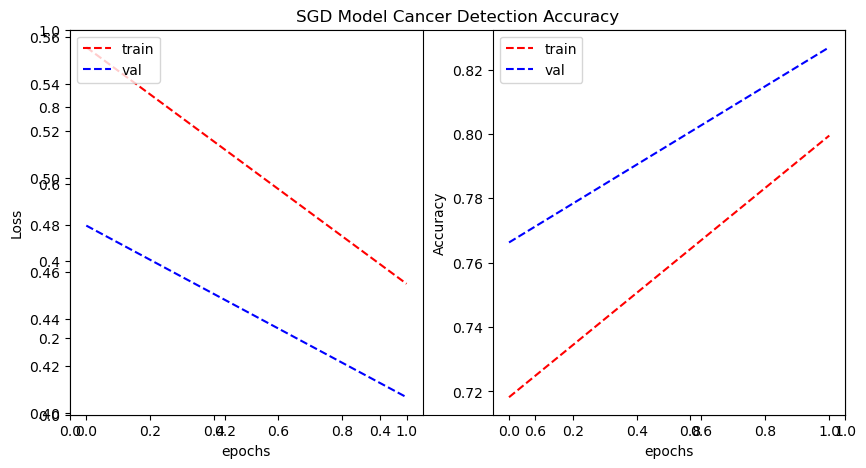

In [38]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [39]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


In [40]:
model.evaluate(test_generator)

  22/4056 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - categorical_accuracy: 0.9716 - loss: 0.2918 

c:\Users\khour\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4056/4056 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - categorical_accuracy: 0.8240 - loss: 0.4094


[0.41131964325904846, 0.8239644765853882]

In [41]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])

In [42]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [43]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

c:\Users\khour\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model_VGG_1_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [61]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=10)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)
history_VGG_1_softmax = model_VGG_1_softmax.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)
history_VGG_1_softmax_relu = model_VGG_1_softmax_relu.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)

Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - categorical_accuracy: 0.9430 - loss: 0.1443 - val_categorical_accuracy: 0.7261 - val_loss: 1.2469
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.9699 - loss: 0.0934 - val_categorical_accuracy: 0.7180 - val_loss: 1.3039
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.9623 - loss: 0.1084 - val_categorical_accuracy: 0.7201 - val_loss: 1.4332
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.9611 - loss: 0.1060 - val_categorical_accuracy: 0.7105 - val_loss: 1.5265
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - categorical_accuracy: 0.9731 - loss: 0.0744 - val_categorical_accuracy: 0.7185 - val_loss: 1.7764
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - categorical_accuracy: 0.9890 - loss: 0.0419 - val_categorical_accuracy: 0.6958 - val_loss: 1.7167
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - categorical_accuracy: 0.978

In [59]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


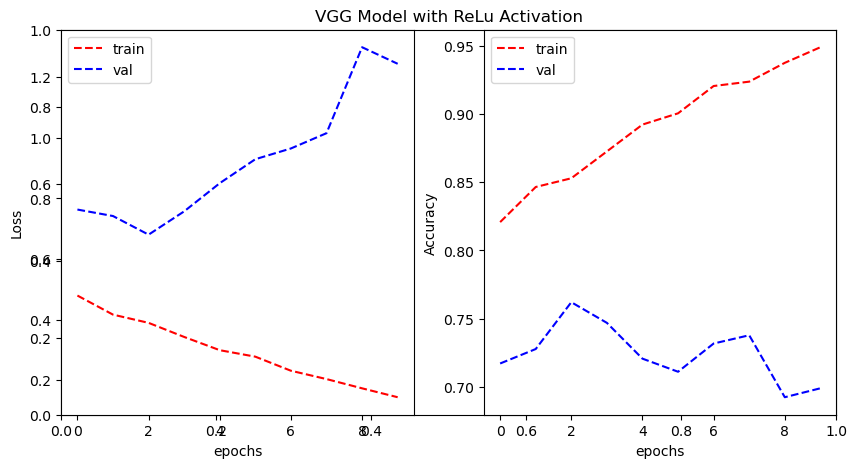

  10/1980 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - categorical_accuracy: 0.8471 - loss: 0.8094  

c:\Users\khour\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - categorical_accuracy: 0.7026 - loss: 1.2970


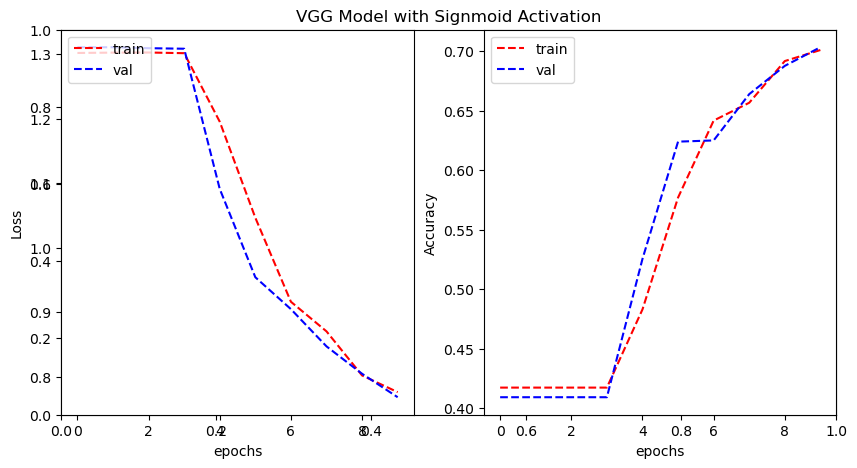

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - categorical_accuracy: 0.7182 - loss: 0.7347


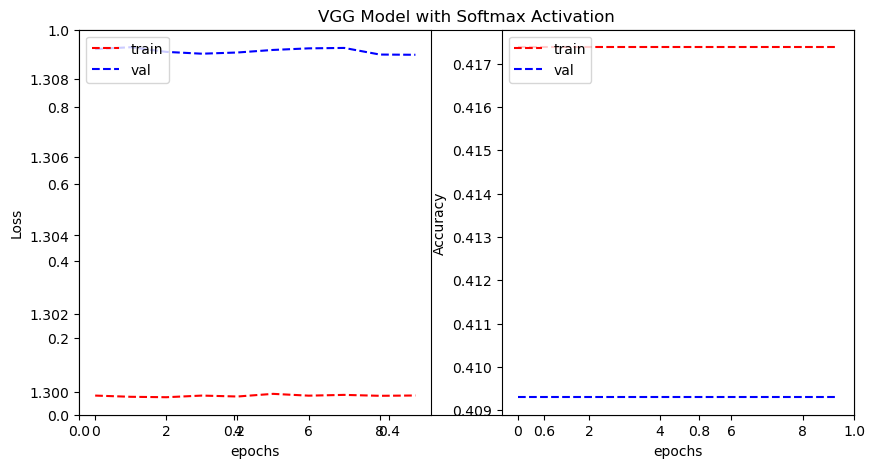

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - categorical_accuracy: 0.3918 - loss: 1.3274


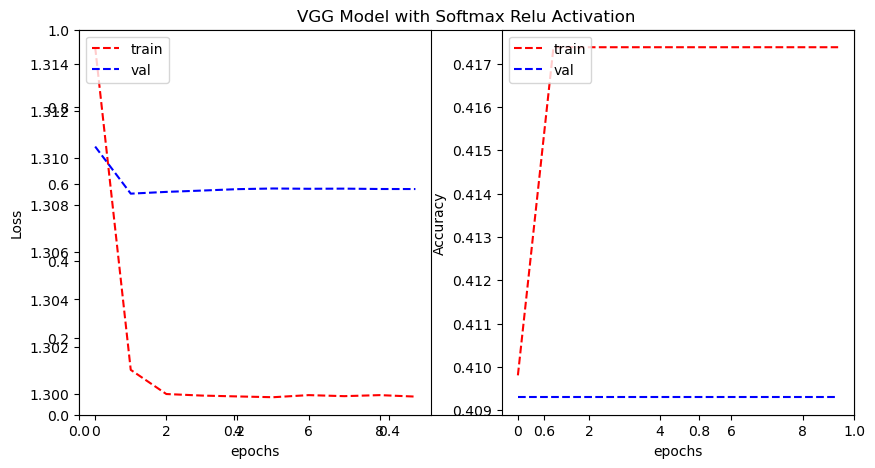

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - categorical_accuracy: 0.3951 - loss: 1.3243


[1.322228193283081, 0.3994949460029602]

In [60]:
plot_learning_curve("VGG Model with ReLu Activation",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)

plot_learning_curve("VGG Model with Signmoid Activation",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)


plot_learning_curve("VGG Model with Softmax Activation",history_VGG_1_softmax.history['loss'], history_VGG_1_softmax.history['val_loss'], 
                    history_VGG_1_softmax.history['categorical_accuracy'], history_VGG_1_softmax.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax.evaluate(test_generator)

plot_learning_curve("VGG Model with Softmax Relu Activation",history_VGG_1_softmax_relu.history['loss'], history_VGG_1_softmax_relu.history['val_loss'], 
                    history_VGG_1_softmax_relu.history['categorical_accuracy'], history_VGG_1_softmax_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax_relu.evaluate(test_generator)

This shows a significant amount of overfitting, due to the model learning valuing irrelevant features like noise resulting in worse performance with new data

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    # preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.2),
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


c:\Users\khour\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 2048, but received input with shape (None, 1152)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 27, 27, 3), dtype=float32)
  • training=True
  • mask=None

Significantly better results just with regularization, will try to fit better later